In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from pandarallel import pandarallel
pandarallel.initialize()

from IPython.display import HTML
from tqdm import tqdm

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%load_ext memory_profiler
%load_ext line_profiler

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# file loading and prep
path_shared = '../data/{}'

games_df = pd.read_csv(path_shared.format('games.csv'))
plays_df = pd.read_csv(path_shared.format('plays.csv'))
players_df = pd.read_csv(path_shared.format('players.csv'))
track_df = pd.read_csv(path_shared.format('week1_norm.csv', usecols=['nflId', 'displayName', 'position', 'team_pos', 'x', 'y', 'v_x', 'v_y', 'v_mag', 'v_theta', 'a_x', 'a_y', 'a_mag', 'a_theta']))
pbp_2018 = pd.read_csv(path_shared.format('play_by_play_2018.csv'), low_memory=False)
pbp_joined = pd.merge(plays_df,pbp_2018,how = "left",left_on = ["gameId", "playId"] ,right_on = ["old_game_id", "play_id"])

pbp_joined["retractable"] = np.where(((pbp_joined['roof'] == "open ") | (pbp_joined['roof'] == "closed")), 1, 0)
pbp_joined["dome"] = np.where((pbp_joined['roof'] == "dome"), 1, 0)
pbp_joined["outdoors"] = np.where((pbp_joined['roof'] == "outdoors"), 1, 0)
pbp_joined["era0"] = 0
pbp_joined["era1"] = 0
pbp_joined["era2"] = 0
pbp_joined["era3"] = 0
pbp_joined["era4"] = 1
pbp_joined["down1"] = np.where((pbp_joined['down_x'] == 1),1,0)
pbp_joined["down2"] = np.where((pbp_joined['down_x'] == 2),1,0)
pbp_joined["down3"] = np.where((pbp_joined['down_x'] == 3),1,0) 
pbp_joined["down4"] = np.where((pbp_joined['down_x'] == 4),1,0)
pbp_joined["home"] = np.where((pbp_joined['posteam'] == pbp_joined['home_team']),1,0)

In [3]:
# out_dir_path = '../data/eppa/{}'
out_dir_path = '/mnt/c/Users/uditr/OneDrive/Projects/BigDataBowl/output/{}'

In [4]:
params = lambda: None # create an empty object to add params
params.a_max = 7
params.s_max = 9
# params.reax_t = params.s_max/params.a_max
params.reax_t = 0.2
params.tti_sigma = 0.45
params.cell_length = 1
params.alpha = 1.5
vars(params)

{'a_max': 7,
 's_max': 9,
 'reax_t': 0.2,
 'tti_sigma': 0.45,
 'cell_length': 1,
 'alpha': 1.5}

In [11]:
plays = list(set(map(lambda x: (x[0].item(), x[1].item()), track_df.groupby(['gameId', 'playId'], as_index=False).first()[['gameId', 'playId']].to_numpy())))
len(plays)

1034

In [12]:
# deep lockett vs chiefs (16)
# game_id = 2018122314
# play_id = 4239

# deep dissly vs bears (2)
# game_id = 2018091700
# play_id = 3936

# deep middle insane gronk (1) 
game_id = 2018090905
play_id = 2062

# game_id = 2018091700
# play_id = 1959

# detroit red zone vs jets (1)
# game_id = 2018091000
# play_id = 3016

# mullens to kittle, def by wagner (13)
# game_id = 2018120213
# play_id = 398

# mullens to bobby, 98yd pick6 (13)
# game_id = 2018120213
# play_id = 3952

# mahomes to tyreek, KJ defense (16)
# game_id = 2018122314
# play_id = 73

# game_id, play_id = random.choice(plays)

# play_df = track_df[(track_df.playId == play_id) & (track_df.gameId == game_id)].sort_values(by = 'frameId')

# ball_snap_frame = play_df.loc[(play_df.nflId == 0) & (play_df.event == 'ball_snap')].frameId.iloc[0]
# pass_forward_frame = play_df.loc[(play_df.nflId == 0) & (play_df.event == 'pass_forward')].frameId.iloc[0]

# play_df['frames_since_snap'] = play_df.frameId - ball_snap_frame
# play_df = play_df.join(los, on=['gameId', 'playId'])
# play_df.reset_index(drop=True, inplace=True)

# play_df.head()

In [13]:
dt = np.float32

dict_keys(['1-closest-defender-distance', '1-closest-defender-x', '1-closest-defender-y', 'y', '5-closest-defender-distance', '5-closest-defender-speed', '2-closest-defender-distance', '2-closest-defender-speed', '4-closest-defender-x', '2-closest-defender-y', '1-closest-defender-speed', '2-closest-defender-x', '3-closest-defender-distance', '4-closest-defender-speed', '5-closest-defender-x', '3-closest-defender-speed', '3-closest-defender-x', '4-closest-defender-y', '3-closest-defender-y', '4-closest-defender-distance', '5-closest-defender-y'])
[05:42:36] /home/udit/.local/lib/python3.8/site-packages/treelite_runtime/predictor.py:309: Dynamic shared library /home/udit/BigDataBowl/analysis/in/xyacmymodel.so has been successfully loaded into memory
[05:42:38] /home/udit/.local/lib/python3.8/site-packages/treelite_runtime/predictor.py:309: Dynamic shared library /home/udit/BigDataBowl/analysis/in/epa_no_time_mymodel.so has been successfully loaded into memory


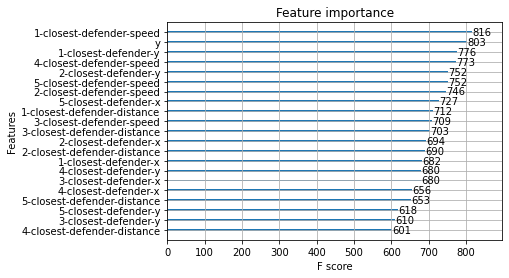

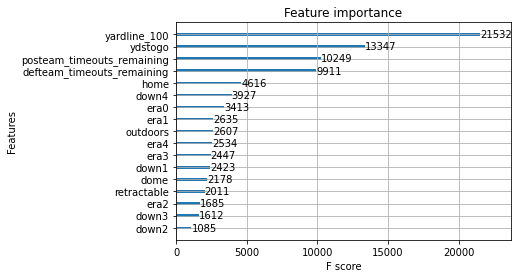

In [14]:
# model constants
T = np.linspace(0.1, 4, 40, dtype=dt)
x = np.linspace(0.5, 119.5, 120, dtype=dt)
y = np.linspace(-0.5, 53.5, 55, dtype=dt)
y[0] = -0.2
xx, yy = np.meshgrid(x, y)
field_locs = np.stack((xx, yy)).reshape(2, -1).T  # (F, 2)

# historical trans model inputs/params
L_given_ts = np.load('in/L_given_t.npy')
T_given_Ls_df = pd.read_pickle('in/T_given_L.pkl')
# from L_given_t in historical notebook
x_min, x_max = -9, 70
y_min, y_max = -39, 40
t_min, t_max = 10, 63

#epa/xyac model loading
import xgboost as xgb
import joblib
import treelite_runtime
bst = joblib.load("./in/xyac_model.model")
xgb.plot_importance(bst)
scores = bst.get_score(importance_type='gain')
print(scores.keys())
cols_when_model_builds = bst.feature_names
xyac_predictor = treelite_runtime.Predictor('./in/xyacmymodel.so', verbose=True)
epa_model = joblib.load("./in/epa_model_rishav_no_time.model")
xgb.plot_importance(epa_model)
scores = epa_model.get_score(importance_type='gain')
cols_when_model_builds_ep = epa_model.feature_names
epa_predictor = treelite_runtime.Predictor('./in/epa_no_time_mymodel.so', verbose=True)

var = None
xyac_b = None

def play_eppa(game_id, play_id, viz_df=True, save_np=False):
    play_df = track_df[(track_df.playId == play_id) & (track_df.gameId == game_id)].sort_values(by = 'frameId')
    
    ball_snap_frame = play_df.loc[(play_df.nflId == 0) & (play_df.event == 'ball_snap')].frameId.iloc[0]
    pass_forward_frame = play_df.loc[(play_df.nflId == 0) & (play_df.event == 'pass_forward')].frameId.iloc[0]
    play_df['frames_since_snap'] = play_df.frameId - ball_snap_frame
    
    # per play epa model
    def getEPAModel():
        epvals = np.array([7,-7,3,-3,2,-2,0])
        joined_df = pbp_joined[(pbp_joined.playId == play_id) & (pbp_joined.gameId == game_id)]
        epa_df = pd.DataFrame({'play_endpoint_x': x})

        test = {}
        for feat in epa_model.feature_names:
            test[feat] = [joined_df.iloc[0][feat]]
            epa_df[feat] = joined_df.iloc[0][feat]

        first_df = pd.DataFrame(test)

        dtest = treelite_runtime.Batch.from_npy2d(first_df[cols_when_model_builds_ep].values)
        ypred = epa_predictor.predict(dtest)
        ep = np.sum(ypred*epvals, axis = 1)
#         print(ep)
#         print("YAY")
        epa_df["before_play_ep"] = ep[0]

        epa_df['los'] = 100 - epa_df['yardline_100']
        epa_df['first_down_line'] = epa_df['los'] + epa_df["ydstogo"] #fix this
        epa_df['expected_end_up_line'] = epa_df['play_endpoint_x']

        epa_df['isFirstDown'] = 0
        epa_df['isFirstDown'] = np.where(epa_df['expected_end_up_line'] >= epa_df['first_down_line'], 1, 0)

        epa_df['yardline_100'] = np.round(110 - epa_df['expected_end_up_line'])
        epa_df['yardline_100'] = np.where(epa_df['yardline_100'] > 100, 100 , epa_df['yardline_100'])
        epa_df['ydstogo'] = epa_df['first_down_line'] - epa_df['expected_end_up_line']
        epa_df['ydstogo'] = np.where(epa_df['isFirstDown'] == 1, 10, epa_df['ydstogo'])
        downthing = joined_df.iloc[0]['down_x']
#         print(downthing)
        for d in range(1,4):
            epa_df['down%d' % d] = 1 if (d == downthing+1) else 0

        epa_df['down1'] = np.where(epa_df['isFirstDown'] == 1, 1, epa_df['down1'])
        epa_df['down2'] = np.where(epa_df['isFirstDown'] == 1, 0, epa_df['down2'])
        epa_df['down3'] = np.where(epa_df['isFirstDown'] == 1, 0, epa_df['down3'])
        epa_df['down4'] = np.where(epa_df['isFirstDown'] == 1, 0, epa_df['down4'])

        ### UPDATE EPA VARIABLES ###

        dtest = treelite_runtime.Batch.from_npy2d(epa_df[cols_when_model_builds_ep].values)
        ypred = epa_predictor.predict(dtest)
        ep = np.sum(ypred*epvals, axis = 1)
        epa_df['xep'] = ep
        ### SCORE SAFETIES
        epa_df['xep'] = np.where(epa_df['play_endpoint_x'] < 10, -2, epa_df['xep'])
        ### SCORE Tds 
        epa_df['xep'] = np.where(epa_df['play_endpoint_x'] > 110, 7, epa_df['xep'])

        epa_df['xepa'] = epa_df['xep'] - epa_df['before_play_ep']

        only_vals = epa_df[["play_endpoint_x", "xep", "xepa"]] # THIS CONTAINS THE EPA VALUES BASED ON PLAY ENDPOINT
        return only_vals
    
    epa_df = getEPAModel()
    
    # input: tracking data for a single frame
    # output: frame_eppa (F, T)... (writes intermediate F,T to disk)
    def frame_eppa(frame_id):
        frame_df = play_df.loc[play_df.frameId==frame_id].reset_index()
        
        # per frame shared calcs
        ball_start = frame_df.loc[frame_df.position=='QB', ['x', 'y']].iloc[0].to_numpy(dtype=dt)
        t = frame_df.frames_since_snap.iloc[0]
        frame_df = frame_df.loc[(frame_df.nflId!=0) & (frame_df.position!='QB')] # remove ball and qb from df
        
        reach_vecs = (field_locs - ball_start).astype(dt)  # (F, 2)
        reach_dist = (np.linalg.norm(reach_vecs, axis=1)).astype(dt)  # (F,)

        # project motion by reaction time
        frame_df['v_x_r'] = frame_df.a_x*params.reax_t+frame_df.v_x
        frame_df['v_y_r'] = frame_df.a_y*params.reax_t+frame_df.v_y
        frame_df['v_r_mag'] = np.linalg.norm(np.array([frame_df.v_x_r, frame_df.v_y_r], dtype=dt), axis=0)
        frame_df['v_r_theta'] = np.arctan(frame_df.v_y_r/frame_df.v_x_r).fillna(0)
        frame_df['x_r'] = frame_df.x + frame_df.v_x*params.reax_t + 0.5*frame_df.a_x*params.reax_t**2
        frame_df['y_r'] = frame_df.y + frame_df.v_y*params.reax_t + 0.5*frame_df.a_y*params.reax_t**2

        player_teams = frame_df['team_pos'].to_numpy() # J,
        player_ids = frame_df['nflId'].to_numpy()
        reaction_player_locs = frame_df[['x_r', 'y_r']].to_numpy(dtype=dt) # (J, 2)
        reaction_player_vels = frame_df[['v_x_r', 'v_y_r']].to_numpy(dtype=dt) #(J,2)

        # intercept vector between each player and field location
        int_d_vec = field_locs[:, None, :] - reaction_player_locs #F, J, 2
        int_d_mag = np.linalg.norm(int_d_vec, axis=2) # F, J
        #projecting player velocity on d_vec to get initial speed along d_vec
        int_s0 = np.clip(np.sum(int_d_vec*reaction_player_vels, axis=2)/int_d_mag, -params.s_max, params.s_max) #F, J,

        # calculate time to int based on phys model
        t_lt_smax = (params.s_max-int_s0)/params.a_max  #F, J,
        d_lt_smax = t_lt_smax*((int_s0+params.s_max)/2) #F, J,
        d_at_smax = int_d_mag - d_lt_smax               #F, J,
        t_at_smax = d_at_smax/params.s_max              #F, J,
        t_tot = t_lt_smax+t_at_smax+params.reax_t       #F, J,

        # int success if T-t_tot = dT <  0. Put through sigmoid to add temporal uncertainty around 
        int_dT = T[None,:,None] - t_tot[:,None,:]         #F, T, J
        p_int = (1/(1. + np.exp( -np.pi/np.sqrt(3.0)/params.tti_sigma * int_dT, dtype=dt) )) #F, T, J

        # input: qb_loc (2,), t=frames_after_snap (int)
        # output: (P(L,T)|t) int probability of each pass (F, T)
        def hist_trans_prob():
            """ P(L|t) """
            ball_start_ind = np.rint(ball_start).astype(int)
#             mask for zeroing out parts of the field that are too far to be thrown to per the L_given_t model
            L_t_mask = np.zeros_like(xx, dtype=dt)  # (Y, X)
            L_t_mask[max(ball_start_ind[1]+y_min,0):min(ball_start_ind[1]+y_max,len(y)-1),\
                     max(ball_start_ind[0]+x_min,0):min(ball_start_ind[0]+x_max,len(x)-1)] = 1.
            L_t_mask = L_t_mask.flatten()  # (F,)
#             # we clip reach vecs to be used to index into L_given_t.
#             # eg if qb is far right, then the left field will be clipped to y=-39 and later zeroed out
#             reach_vecs_int = np.rint(reach_vecs).astype(int)
            
#             clipped_reach_vecs = np.stack((np.clip(reach_vecs_int[:,0], x_min, x_max),
#                                           np.clip(-reach_vecs_int[:,1], y_min, y_max)))  # (2, F)
#             t_i = max(t-t_min, 0)
#             L_given_t = L_given_ts[t_i, clipped_reach_vecs[1]-y_min, clipped_reach_vecs[0]-x_min] * L_t_mask  # (F,) ; index with y and then x
            L_given_t = L_t_mask #changed L_given_t to uniform after discussion
            L_given_t /= L_given_t.sum()  # renormalize since part of L|t may have been off field

            """ P(T|L) """
            # we find T|L for sufficiently close spots (1 < L <= 60)
            reach_dist_int = np.rint(np.linalg.norm(reach_vecs, axis=1)).astype(int)  # (F,)
            reach_dist_in_bounds_idx = (reach_dist_int > 1) & (reach_dist_int <= 60)
            reach_dist_in_bounds = reach_dist_int[reach_dist_in_bounds_idx]
            T_given_L_subset = T_given_Ls_df.set_index('dist').loc[reach_dist_in_bounds, 'p'].to_numpy(dtype=dt)\
                .reshape(len(reach_dist_in_bounds), -1)  # (F~, T) ; F~ is subset of F that is in [1, 60] yds from ball
            T_given_L = np.zeros((len(field_locs), len(T)), dtype=dt)  # (F, T)
            # fill in the subset of values computed above
            T_given_L[reach_dist_in_bounds_idx] = T_given_L_subset

            L_T_given_t = L_given_t[:,None] * T_given_L #(F, T)
            return L_T_given_t

        def comp_prob():
            # use p_int as memoized values for integration

            # trajectory integration
            g = 10.72468 #y/s/s
            dx = reach_vecs[:, 0] #F
            dy = reach_vecs[:, 1] #F
            vx = dx[:, None]/T[None, :]   #F, T
            vy = dy[:, None]/T[None, :]   #F, T
            vz_0 = (T*g)/2                #T

            # note that idx (i, j, k) into below arrays is invalid when j < k
            traj_ts = np.tile(T, (len(field_locs), len(T), 1)) #(F, T, T)
            traj_locs_x_idx = np.rint(np.clip((ball_start[0]+vx[:, :, None]*T), 0, len(x)-1)).astype(int) # F, T, T
            traj_locs_y_idx = np.rint(np.clip((ball_start[1]+vy[:, :, None]*T), 0, len(y)-1)).astype(int) # F, T, T
            traj_locs_z = 2.0+vz_0[None, :, None]*traj_ts-0.5*g*traj_ts*traj_ts #F, T, T
            path_idxs = np.ravel_multi_index(np.stack((traj_locs_y_idx, traj_locs_x_idx)).reshape(2, -1), xx.shape)  # (F*T*T,)
            traj_t_idxs = np.rint(10*traj_ts - 1).flatten().astype(int)  # (F, T, T)
            p_int_traj = p_int[path_idxs, traj_t_idxs] # F*T*T, J
            p_int_traj = p_int_traj.reshape((*traj_locs_x_idx.shape, len(reaction_player_locs)))  # F, T, T, J

            # account for ball height on traj and normalize each locations int probability
            lambda_z = np.where((traj_locs_z<3)&(traj_locs_z>0), 1, 0) #F, T, T # maybe change this to a normal distribution 
            p_int_traj = p_int_traj * lambda_z[:, :, :, None]
            norm_factor = np.maximum(1., p_int_traj.sum(axis=-1))  #F, T, T
            p_int_traj_norm = (p_int_traj/norm_factor[..., None])  #F, T, T, J

            # independent int probs at each point on trajectory
            all_p_int_traj = np.sum(p_int_traj_norm, axis=-1)  # F, T, T
            off_p_int_traj = np.sum(p_int_traj_norm, axis=-1, where=(player_teams=='OFF'))
            def_p_int_traj = np.sum(p_int_traj_norm, axis=-1, where=(player_teams=='DEF'))
            ind_p_int_traj = p_int_traj_norm #use for analyzing specific players

            # calc decaying residual probs after you take away p_int on earlier times in the traj 
            compl_all_p_int_traj = 1-all_p_int_traj  # F, T, T
            remaining_compl_p_int_traj = np.cumprod(compl_all_p_int_traj, axis=-1)  # F, T, T
            # maximum 0 because if it goes negative the pass has been caught by then and theres no residual probability
            shift_compl_cumsum = np.roll(remaining_compl_p_int_traj, 1, axis=-1)  # F, T, T
            shift_compl_cumsum[:, :, 0] = 1

            # multiply residual prob by p_int at that location
            all_completion_prob_dt = shift_compl_cumsum * all_p_int_traj  # F, T, T
            off_completion_prob_dt = shift_compl_cumsum * off_p_int_traj  # F, T, T
            def_completion_prob_dt = shift_compl_cumsum * def_p_int_traj  # F, T, T
            ind_completion_prob_dt = shift_compl_cumsum[:, :, :, None] * ind_p_int_traj  # F, T, T, J

            # now accumulate values over total traj for each team and take at T=t
            all_completion_prob = np.cumsum(all_completion_prob_dt, axis=-1)  # F, T, T
            off_completion_prob = np.cumsum(off_completion_prob_dt, axis=-1)  # F, T, T
            def_completion_prob = np.cumsum(def_completion_prob_dt, axis=-1)  # F, T, T
            ind_completion_prob = np.cumsum(ind_completion_prob_dt, axis=-2)  # F, T, T, J

                #     #### Toy example
        #         all_p_int_traj = [0, 0, 0.1, 0.2, 0.8, 0.8]
        #         c_all_p_int_traj=[1, 1, 0.9, 0.8, 0.2, 0.2]
        #         rem_compl_p_int_traj = [1, 1, 0.9, 0.72, 0.144, 0.0288]
        #         0.1 + 0.9*0.2 + 0.72 * 0.8 + 0.144*0.8 = 0.9712
        #         adjust_compl_prob =        [0, 0, 0.1, 0.28, 0.84, 0.84]


            # this einsum takes the diagonal values over the last two axes where T = t
            # this takes care of the t > T issue.
            all_p_int_pass = np.einsum('ijj->ij', all_completion_prob)  # F, T
            off_p_int_pass = np.einsum('ijj->ij', off_completion_prob)  # F, T
            def_p_int_pass = np.einsum('ijj->ij', def_completion_prob)  # F, T
            ind_p_int_pass = np.einsum('ijjk->ijk', ind_completion_prob)  # F, T, J
            no_p_int_pass = 1-all_p_int_pass #F, T

            assert np.allclose(all_p_int_pass, off_p_int_pass + def_p_int_pass, atol=0.01)
            assert np.allclose(all_p_int_pass, ind_p_int_pass.sum(-1), atol=0.01)
            return off_p_int_pass, def_p_int_pass, ind_p_int_pass

            # below gets cutoff for combined model
            # this is only for viz (in reality want to keep F, T above and mult by value/transition prob)
    #         field_p_int_all = all_p_int_pass.mean(axis=1)  # F,
    #         field_p_int_off = off_p_int_pass.mean(axis=1)  # F, 
    #         field_p_int_def = def_p_int_pass.mean(axis=1)  # F,
    #         field_p_no_int = 1-field_p_int_all
    #         assert np.allclose(field_p_int_all, field_p_int_off + field_p_int_def, atol=0.01)
    #         assert np.all(field_p_int_all <= 1.01) and np.all(field_p_int_all >= -0.01)
    #         assert np.all(field_p_int_off <= 1.01) and np.all(field_p_int_off >= -0.01)
    #         assert np.all(field_p_int_def <= 1.01) and np.all(field_p_int_def >= -0.01)

    #         field_df = pd.DataFrame({
    #             'ball_start_x': ball_start[0],
    #             'ball_start_y': ball_start[1], 
    #             'ball_end_x': field_locs[:,0],
    #             'ball_end_y': field_locs[:,1],
    #             'p_mass_1': (((field_p_int_off-field_p_int_def)+1.)/2.).round(3),
    #             'p_mass_2': field_p_no_int.round(3),
    #             # 'p_mass_players': p_int_norm,
    #         })

    #         return field_df

        def xyac():
            receivers_df = frame_df.loc[frame_df.team_pos == 'DEF',['x_r', 'y_r', 'v_x_r', 'v_y_r', 'v_r_theta', 'v_r_mag', 'los', 'a_x', 'a_y']]
#             dist_from_ball_np = np.linalg.norm((receivers_df.x - ball_start[0],
#                                                              receivers_df.y - ball_start[1]), axis=0)
            # find the spot the qb would aim at, leading the receiver in their current dir by the ball time
    #         rec_x_np = receivers_df.x.to_numpy()[:,None]
    #         rec_y_np = receivers_df.y.to_numpy()[:,None]
    #         rec_v_x_np = receivers_df.v_x.to_numpy()[:,None]
    #         rec_v_y_np = receivers_df.v_y.to_numpy()[:,None]
    #         rec_a_x_np = receivers_df.a_x.to_numpy()[:,None]
    #         rec_a_y_np = receivers_df.a_y.to_numpy()[:,None]
    #         rec_v_theta_np = receivers_df.v_theta.to_numpy()[:,None]
            rec_v_x_r = receivers_df.v_x_r.to_numpy()[:,None]
            rec_v_y_r = receivers_df.v_y_r.to_numpy()[:,None]
            rec_v_r_mag = receivers_df.v_r_mag.to_numpy()[:,None]
            rec_v_r_theta = receivers_df.v_r_theta.to_numpy()[:,None]
            x_r = receivers_df.x_r.to_numpy()[:,None] #(J, 1)
            y_r = receivers_df.y_r.to_numpy()[:,None] #(J, 1)

            #target_x = rec_x_np+rec_v_x_np*t+0.5*rec_a_x_np*t**2  # (R, T)
            #target_y = rec_y_np+rec_v_y_np*t+0.5*rec_a_y_np*t**2  # (R, T)

    #         x_r = rec_x_np + rec_v_x_np*params.reax_t + 0.5*rec_a_x_np*params.reax_t**2 #(J, 1)
    #         y_r = rec_y_np + rec_v_y_np*params.reax_t + 0.5*rec_a_y_np*params.reax_t**2 #(J, 1)

            reaction_player_locs = np.hstack((x_r, y_r)) # (J,2)
            reaction_player_vels = np.hstack((rec_v_x_r, rec_v_y_r)) # (J,2)

            int_d_vec = field_locs[:, None, :] - reaction_player_locs #(F, J, 2)
            int_d_mag = np.linalg.norm(int_d_vec, axis=2) # F, J
            int_theta = np.arctan(int_d_vec[:,:,1]/int_d_vec[:,:,0]) #this could be a problem


            int_s0 = np.clip(np.sum(int_d_vec*reaction_player_vels, axis=2)/int_d_mag, -params.s_max, params.s_max) #F, J,  #taking norm between vectors int_d and player velocity

            t_lt_smax = (params.s_max-int_s0)/params.a_max  #F, J,
            d_lt_smax = t_lt_smax*((int_s0+params.s_max)/2) #F, J,
            d_at_smax = int_d_mag - d_lt_smax               #F, J,
            t_at_smax = d_at_smax/params.s_max              #F, J,
            t_tot = t_lt_smax+t_at_smax+params.reax_t       #F, J,


            t_without_react = t_tot - params.reax_t 
            tempT = np.clip(T - params.reax_t, 0, 4)

            cap = np.broadcast_to(t_without_react[:,:,None],(*t_lt_smax.shape, len(T))) 
            a1 =  np.broadcast_to(t_lt_smax[:,:,None],(*t_lt_smax.shape, len(T))) # F, J, T THIS IS TIME SPENT LT SMAX
            a2 =  np.broadcast_to(tempT[None,None,:],(*t_lt_smax.shape, len(T))) # F, J, T
            newT = np.where(a2 > cap, cap, a2)
            a3 =  np.broadcast_to(newT,(*t_lt_smax.shape, len(T))) # F, J, T

            time_lt_smax = np.where(a1 > a3, a3, a1) # F, J, T  THIS IS TIME LESS THAN MAX
            time_at_smax = a3 - time_lt_smax # F, J, T THIS IS TIME MORE at max



            d = time_at_smax * params.s_max + int_s0[:,:,None]*time_lt_smax + 0.5*params.a_max*np.square(time_lt_smax) # F, J, T
            # d should be at most the magnitude

            #print(d)
            #print(int_s0)
            ## d = Time at max speed * max speed + int_s0* time at lt_smax + 1/2 params.a_max (time at lt_smax * time at lt_smax) 
            #d = 
            v_proj = int_s0[:,:,None] + params.a_max*time_lt_smax # F, J, T
            v_proj = np.where(v_proj > params.s_max, params.s_max, v_proj) # F, J, T
            #v_proj = np.abs(v_proj)
            x_proj = x_r + d* np.cos(int_theta[:,:,None]) # F, J, T
            y_proj = y_r + d* np.sin(int_theta[:,:,None]) # F, J, T

            x_proj_relv = x_proj -  field_locs[:,None,None,0] # F, J, T #GET RELATIVE COORDS
            y_proj_relv = y_proj -  field_locs[:,None,None,1] # F, J, T #GET RELATIVE COORDS


            projected_locations = np.stack((x_proj, y_proj), axis =3)  # F, J, T, 2

            distances_to_ball = projected_locations - field_locs[:,None,None,:] # F, J, T, 2
            distance_mags = np.linalg.norm(distances_to_ball, axis = 3) # F, J, T

            sorted_indices = np.argsort(distance_mags, axis = 1) # F, J, T

            distance_mags = np.take_along_axis(distance_mags,sorted_indices, axis = 1)
            x_proj_sorted = np.take_along_axis(x_proj_relv,sorted_indices, axis = 1) # F, J, T
            y_proj_sorted = np.take_along_axis(y_proj_relv,sorted_indices, axis = 1) # F, J, T
            v_proj_sorted = np.take_along_axis(v_proj,sorted_indices, axis = 1) # F, J, T

            just_top_5_distances = distance_mags[:,0:5,:].transpose((0,2,1)) #F, T, 5
            just_top_5_x_proj = x_proj_sorted[:,0:5,:].transpose((0,2,1)) #F, T, 5
            just_top_5_y_proj = y_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5
            just_top_5_v_proj = v_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5


            just_top_5_distances = np.reshape(just_top_5_distances, (just_top_5_distances.shape[0]*just_top_5_distances.shape[1],just_top_5_distances.shape[2]))
            just_top_5_x_proj  = np.reshape(just_top_5_x_proj, just_top_5_distances.shape)
            just_top_5_y_proj  = np.reshape(just_top_5_y_proj, just_top_5_distances.shape)
            just_top_5_v_proj  = np.reshape(just_top_5_v_proj, just_top_5_distances.shape)


            endpoints = np.repeat(field_locs, repeats = len(T), axis = 0) # FxT, 2
#             assert((field_locs[:, None, :]+np.zeros_like(T[None, None, :])).reshape(end))
            times = np.repeat(T[None, :], repeats = len(field_locs), axis = 0)
            times_shaped = times.reshape((times.shape[0]*times.shape[1]))# FxT, 1
            value_array = np.array([-2.5,2.5,7.5,12.5,17.5, 22.5, 27.5, 30])


            field_df = pd.DataFrame({
                'pass_endpoint_x': endpoints[:,0],
                'pass_endpoint_y': endpoints[:,1],
                'frame_thrown' : t,
                'time_of_flight' : times_shaped,
                '1-closest-defender-distance' : just_top_5_distances[:,0],
                '2-closest-defender-distance' : just_top_5_distances[:,1],
                '3-closest-defender-distance' : just_top_5_distances[:,2],
                '4-closest-defender-distance' : just_top_5_distances[:,3],
                '5-closest-defender-distance' : just_top_5_distances[:,4],
                '1-closest-defender-x' : just_top_5_x_proj[:,0],
                '2-closest-defender-x' : just_top_5_x_proj[:,1],
                '3-closest-defender-x' : just_top_5_x_proj[:,2],
                '4-closest-defender-x' : just_top_5_x_proj[:,3],
                '5-closest-defender-x' : just_top_5_x_proj[:,4],
                '1-closest-defender-y' : just_top_5_y_proj[:,0], 
                '2-closest-defender-y': just_top_5_y_proj[:,1], 
                '3-closest-defender-y': just_top_5_y_proj[:,2], 
                '4-closest-defender-y': just_top_5_y_proj[:,3], 
                '5-closest-defender-y': just_top_5_y_proj[:,4], 
                '1-closest-defender-speed' : just_top_5_v_proj[:,0],
                '2-closest-defender-speed': just_top_5_v_proj[:,1],
                '3-closest-defender-speed': just_top_5_v_proj[:,2],
                '4-closest-defender-speed': just_top_5_v_proj[:,3],
                '5-closest-defender-speed': just_top_5_v_proj[:,4], 
                "y" : endpoints[:,1]

             })
            ### CALCULTE XYAC

            dtest = treelite_runtime.Batch.from_npy2d(field_df[cols_when_model_builds].values)
            ypred = xyac_predictor.predict(dtest)
            y_vals = np.sum(ypred*value_array, axis = 1)
            field_df['xyac'] = y_vals
            field_df['play_endpoint_x'] = np.round(field_df['xyac'] + field_df['pass_endpoint_x'])
            field_df['play_endpoint_x'] = field_df['play_endpoint_x']+.5
            field_df['play_endpoint_x'] = np.clip(field_df['play_endpoint_x'], 0.5, 119.5)

            return field_df[['pass_endpoint_x', 'pass_endpoint_y', 'time_of_flight', 'xyac', 'play_endpoint_x']]

        
        nonlocal epa_df
        
        ppc_off, ppc_def, ppc_ind = comp_prob() #(F, T), (F, T), (F, T, J)
        ind_info = np.stack((player_ids, player_teams), axis=1)
        h_trans_prob = hist_trans_prob()
        
        epa_xyac_df = xyac().merge(epa_df, how='left', on='play_endpoint_x')
        xyac = epa_xyac_df.xyac.to_numpy().reshape(ppc_off.shape)
        end_x = epa_xyac_df.play_endpoint_x.to_numpy().reshape(ppc_off.shape)
        xepa = epa_xyac_df.xepa.to_numpy().reshape(ppc_off.shape)
        assert(h_trans_prob.shape == ppc_off.shape)

        ppc = ppc_off
        ppc_no = 1-ppc_off-ppc_def
        trans_prob = h_trans_prob * np.power(ppc, params.alpha) #F, T
        trans_prob /= trans_prob.sum()


        eppa = ppc*trans_prob*xepa
        eppa_ind = ppc_ind*trans_prob[:, :, None]*xepa[:, :, None]
        
        if save_np:
            dir = out_dir_path.format(f'{game_id}/{play_id}')
            Path(dir).mkdir(parents=True, exist_ok=True)
            np.savez_compressed(f'{dir}/{frame_id}', players_ind_info=ind_info,
                                ppc_ind=ppc_ind, h_trans=h_trans_prob, xepa=xepa, eppa_ind=eppa_ind)
        if viz_df:
            field_df = pd.DataFrame({
                'frameId': frame_id,
                'ball_end_x': field_locs[:,0],
                'ball_end_y': field_locs[:,1],
                'eppa': eppa.sum(axis=1),
                'hist_trans': h_trans_prob.sum(axis=1),
                'trans': trans_prob.sum(axis=1), #sum when pdf of T has been factored
                'ppcf_off': ppc_off.mean(axis=1), # otws mean for mean uniformt T pdf assumption
                'ppcf_def': ppc_def.mean(axis=1),
                'ppcf_no': ppc_no.mean(axis=1),
                # 'ppcf_old': ppc_old.sum(axis=1),
                'ht_ppc_off': (h_trans_prob*ppc_off).sum(axis=1),
                'ht_ppc_def': (h_trans_prob*ppc_def).sum(axis=1),
                't_ppc_off': (trans_prob*ppc_off).sum(axis=1),
                't_ppc_def': (trans_prob*ppc_def).sum(axis=1),
                'xyac': xyac.mean(axis=1),
                'xepa': xepa.mean(axis=1)
                # 'txoff': (trans_prob*throw_int_prob_off).sum(axis=1),
                # 'txdef': (trans_prob*throw_int_prob_def).sum(axis=1),
            })
            field_df.loc[field_df.ball_end_x<ball_start[0]-10, :] = np.nan # remove backward passes
#             display(field_df.tail(5))
#             display(epa_xyac_df.tail(5))
#             global var
#             import copy
#             var = vars()
            return field_df
        
        print(field_df.head(5))
        print(epa_xyac_df.head(5))
        return pd.DataFrame() #empty df if no viz
    
    field_dfs = pd.DataFrame()
    for id in tqdm(range(ball_snap_frame, pass_forward_frame+1)):
        field_dfs = field_dfs.append(frame_eppa(id))
    return play_df, field_dfs

In [15]:
dt = np.float32

%memit play_df, field_dfs = play_eppa(game_id, play_id, save_np=True)

  0%|          | 0/36 [00:00<?, ?it/s]Process MemTimer-1:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/udit/.local/lib/python3.8/site-packages/memory_profiler.py", line 225, in run
    stop = self.pipe.poll(self.interval)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt
  0%|          | 0/36 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'eppa': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [30]:
from visualize import AnimatePlay
# field_dfs['xyac'] = 
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'trans': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [38]:
vals = []
for l in sorted(os.listdir(out_dir_path.format(f'{game_id}/{play_id}'))):
    vals.append((l, np.load(out_dir_path.format(f'{game_id}/{play_id}/{l}/ppc.npz'))['ppc_ind']))

(6600, 40, 13)

In [23]:
print(np.array(list(map(lambda x: x[0], vals))))

np.array(list(map(np.sum, list(map(lambda x: x[1], vals)))))

['11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24'
 '25' '26' '27' '28' '29' '30' '31' '32' '33' '34']


array([0.53550413, 0.53048827, 0.55853579, 0.62652983, 0.70083676,
       0.77531949, 0.79430562, 0.82492058, 0.83830705, 0.85842066,
       0.8819233 , 0.91228535, 0.93074132, 0.96470541, 1.00720428,
       1.03947854, 1.07831209, 1.09267778, 1.1283853 , 1.16526965,
       1.18179008, 1.21518201, 1.24264747, 1.24237483])

In [27]:
best_passes = dict()
for f_id, eppa in vals:
    f, t = np.unravel_index(eppa.argmax(), eppa.shape)
    y, x = np.unravel_index(f, xx.shape)
    best_passes[f_id] = (x, y, t, (eppa.max()).round(5))
    
best_passes

{'11': (82, 8, 10, 0.00103),
 '12': (83, 8, 10, 0.00118),
 '13': (84, 8, 10, 0.00133),
 '14': (85, 8, 10, 0.00142),
 '15': (85, 8, 10, 0.00146),
 '16': (85, 9, 9, 0.00127),
 '17': (86, 45, 8, 0.00116),
 '18': (88, 45, 8, 0.00115),
 '19': (88, 45, 8, 0.00118),
 '20': (88, 47, 8, 0.0012),
 '21': (89, 47, 8, 0.00111),
 '22': (88, 45, 7, 0.00112),
 '23': (91, 47, 8, 0.00101),
 '24': (90, 19, 7, 0.00077),
 '25': (96, 30, 8, 0.00081),
 '26': (94, 29, 8, 0.00102),
 '27': (95, 30, 8, 0.00122),
 '28': (92, 29, 8, 0.00133),
 '29': (93, 30, 8, 0.00104),
 '30': (93, 30, 8, 0.00102),
 '31': (93, 29, 7, 0.00105),
 '32': (94, 29, 8, 0.00103),
 '33': (88, 28, 6, 0.00094),
 '34': (92, 27, 7, 0.00091)}

Parrallel Big run

In [25]:
import multiprocessing
from joblib import Parallel, delayed

def parr_eppa(gid, pid):
    try:
        play_eppa(gid, pid, viz_df=False, save_np=True)
    except:
        pass

# num_cores = multiprocessing.cpu_count()
num_cores = 2
inputs = [2018090909]

Parallel(n_jobs=num_cores)(delayed(parr_eppa)(i) for i in inputs)


PicklingError: Could not pickle the task to send it to the workers.

In [23]:
plays[:3]

[(2018090909, 4050), (2018090901, 1306), (2018090912, 3805)]

# Everything below is non-combined models and old stuff

In [ ]:
# input: tracking frame
# output: (all, off, def, no) int probability of each pass (F, T)
def comp_prob(play_frame_group):
    # remove ball and qb from df
    frame_df = play_frame_group.loc[(play_df.nflId!=0)]
    ball_start = frame_df.loc[frame_df.position=='QB'][['x', 'y']].iloc[0].round().to_numpy(dtype=dt)
    frame_df = frame_df.loc[frame_df.position!='QB']
    
    # project motion by reaction time
    frame_df['v_x_r'] = frame_df.a_x*params.reax_t+frame_df.v_x
    frame_df['v_y_r'] = frame_df.a_y*params.reax_t+frame_df.v_y
    frame_df['v_r_mag'] = np.linalg.norm(np.array([frame_df.v_x_r, frame_df.v_y_r]), axis=0)
    frame_df['v_r_theta'] = np.arctan(frame_df.v_y_r/frame_df.v_x_r).fillna(0)
    frame_df['x_r'] = frame_df.x + frame_df.v_x*params.reax_t + 0.5*frame_df.a_x*params.reax_t**2
    frame_df['y_r'] = frame_df.y + frame_df.v_y*params.reax_t + 0.5*frame_df.a_y*params.reax_t**2

    # generate pass arrays
    x = np.linspace(0.5, 119.5, 120, dtype=dt)
    y = np.linspace(-0.5, 53.5, 55, dtype=dt)
    y[0] = -0.2
    xx, yy = np.meshgrid(x, y)
    field_locs = np.stack((xx, yy)).reshape(2, -1).T  # (F, 2)
    T = np.linspace(0.1, 4, 40, dtype=dt) # (T,)

    player_teams = frame_df['team_pos'].to_numpy() # J,
    player_ids = frame_df['nflId'].to_numpy()
    reaction_player_locs = frame_df[['x_r', 'y_r']].to_numpy(dtype=dt) # (J, 2)
    reaction_player_vels = frame_df[['v_x_r', 'v_y_r']].to_numpy(dtype=dt) #(J,2)

    # intercept vector between each player and field location
    int_d_vec = field_locs[:, None, :] - reaction_player_locs #F, J, 2
    int_d_mag = np.linalg.norm(int_d_vec, axis=2) # F, J
    #projecting player velocity on d_vec to get initial speed along d_vec
    int_s0 = np.clip(np.sum(int_d_vec*reaction_player_vels, axis=2)/int_d_mag, -params.s_max, params.s_max) #F, J,

    # calculate time to int based on phys model
    t_lt_smax = (params.s_max-int_s0)/params.a_max  #F, J,
    d_lt_smax = t_lt_smax*((int_s0+params.s_max)/2) #F, J,
    d_at_smax = int_d_mag - d_lt_smax               #F, J,
    t_at_smax = d_at_smax/params.s_max              #F, J,
    t_tot = t_lt_smax+t_at_smax+params.reax_t       #F, J,

    # int success if T-t_tot = dT <  0. Put through sigmoid to add temporal uncertainty around 
    int_dT = T[None,:,None] - t_tot[:,None,:]         #F, T, J
    p_int = (1/(1. + np.exp( -np.pi/np.sqrt(3.0)/params.tti_sigma * int_dT, dtype=dt) )) #F, T, J
    # use p_int as memoized values for integration

    # trajectory integration
    g = 10.72468 #y/s/s
    reach_vecs = ball_start - field_locs  # (F, 2)
    dx = -reach_vecs[:, 0] #F
    dy = -reach_vecs[:, 1] #F
    vx = dx[:, None]/T[None, :]   #F, T
    vy = dy[:, None]/T[None, :]   #F, T
    vz_0 = (T*g)/2                #T

    # note that idx (i, j, k) into below arrays is invalid when j < k
    traj_ts = np.tile(T, (len(field_locs), len(T), 1)) #(F, T, T)
    traj_locs_x_idx = np.rint(np.clip((ball_start[0]+vx[:, :, None]*T), 0, len(x)-1)).astype(int) # F, T, T
    traj_locs_y_idx = np.rint(np.clip((ball_start[1]+vy[:, :, None]*T), 0, len(y)-1)).astype(int) # F, T, T
    traj_locs_z = 2.0+vz_0[None, :, None]*traj_ts-0.5*g*traj_ts*traj_ts #F, T, T
    path_idxs = np.ravel_multi_index(np.stack((traj_locs_y_idx, traj_locs_x_idx)).reshape(2, -1), xx.shape)  # (F*T*T,)
    traj_t_idxs = np.rint(10*traj_ts - 1).flatten().astype(int)  # (F, T, T)
    p_int_traj = p_int[path_idxs, traj_t_idxs] # F*T*T, J
    p_int_traj = p_int_traj.reshape((*traj_locs_x_idx.shape, len(reaction_player_locs)))  # F, T, T, J
    
    # account for ball height on traj and normalize each locations int probability
    lambda_z = np.where((traj_locs_z<3)&(traj_locs_z>0), 1, 0) #F, T, T # maybe change this to a normal distribution 
    p_int_traj = p_int_traj * lambda_z[:, :, :, None]
    norm_factor = np.maximum(1., p_int_traj.sum(axis=-1))  #F, T, T
    p_int_traj_norm = (p_int_traj/norm_factor[..., None])  #F, T, T, J

    # independent int probs at each point on trajectory
    all_p_int_traj = np.sum(p_int_traj_norm, axis=-1)  # F, T, T
    off_p_int_traj = np.sum(p_int_traj_norm, axis=-1, where=(player_teams=='OFF'))
    def_p_int_traj = np.sum(p_int_traj_norm, axis=-1, where=(player_teams=='DEF'))
    ind_p_int_traj = p_int_traj_norm #use for analyzing specific players

    # calc decaying residual probs after you take away p_int on earlier times in the traj 
    compl_all_p_int_traj = 1-all_p_int_traj  # F, T, T
    remaining_compl_p_int_traj = np.cumprod(compl_all_p_int_traj, axis=-1)  # F, T, T
    # maximum 0 because if it goes negative the pass has been caught by then and theres no residual probability
    shift_compl_cumsum = np.roll(remaining_compl_p_int_traj, 1, axis=-1)  # F, T, T
    shift_compl_cumsum[:, :, 0] = 1
    
    # multiply residual prob by p_int at that location
    all_completion_prob_dt = shift_compl_cumsum * all_p_int_traj  # F, T, T
    off_completion_prob_dt = shift_compl_cumsum * off_p_int_traj  # F, T, T
    def_completion_prob_dt = shift_compl_cumsum * def_p_int_traj  # F, T, T
    ind_completion_prob_dt = shift_compl_cumsum[:, :, :, None] * ind_p_int_traj  # F, T, T, J
    
    # now accumulate values over total traj for each team and take at T=t
    all_completion_prob = np.cumsum(all_completion_prob_dt, axis=-1)  # F, T, T
    off_completion_prob = np.cumsum(off_completion_prob_dt, axis=-1)  # F, T, T
    def_completion_prob = np.cumsum(def_completion_prob_dt, axis=-1)  # F, T, T
    ind_completion_prob = np.cumsum(ind_completion_prob_dt, axis=-2)  # F, T, T, J

        #     #### Toy example
#         all_p_int_traj = [0, 0, 0.1, 0.2, 0.8, 0.8]
#         c_all_p_int_traj=[1, 1, 0.9, 0.8, 0.2, 0.2]
#         rem_compl_p_int_traj = [1, 1, 0.9, 0.72, 0.144, 0.0288]
#         0.1 + 0.9*0.2 + 0.72 * 0.8 + 0.144*0.8 = 0.9712
#         adjust_compl_prob =        [0, 0, 0.1, 0.28, 0.84, 0.84]


    # this einsum takes the diagonal values over the last two axes where T = t
    # this takes care of the t > T issue.
    all_p_int_pass = np.einsum('ijj->ij', all_completion_prob)  # F, T
    off_p_int_pass = np.einsum('ijj->ij', off_completion_prob)  # F, T
    def_p_int_pass = np.einsum('ijj->ij', def_completion_prob)  # F, T
    ind_p_int_pass = np.einsum('ijjk->ijk', ind_completion_prob)  # F, T, J
    no_p_int_pass = 1-all_p_int_pass #F, T

    assert np.allclose(all_p_int_pass, off_p_int_pass + def_p_int_pass, atol=0.01)
    assert np.allclose(all_p_int_pass, ind_p_int_pass.sum(-1), atol=0.01)
    return off_p_int_pass, def_p_int_pass, ind_p_int_pass

    # below gets cutoff for combined model
    # this is only for viz (in reality want to keep F, T above and mult by value/transition prob)
    field_p_int_all = all_p_int_pass.mean(axis=1)  # F,
    field_p_int_off = off_p_int_pass.mean(axis=1)  # F, 
    field_p_int_def = def_p_int_pass.mean(axis=1)  # F,
    field_p_no_int = 1-field_p_int_all
    assert np.allclose(field_p_int_all, field_p_int_off + field_p_int_def, atol=0.01)
    assert np.all(field_p_int_all <= 1.01) and np.all(field_p_int_all >= -0.01)
    assert np.all(field_p_int_off <= 1.01) and np.all(field_p_int_off >= -0.01)
    assert np.all(field_p_int_def <= 1.01) and np.all(field_p_int_def >= -0.01)

    field_df = pd.DataFrame({
        'ball_start_x': ball_start[0],
        'ball_start_y': ball_start[1], 
        'ball_end_x': field_locs[:,0],
        'ball_end_y': field_locs[:,1],
        'p_mass_1': (((field_p_int_off-field_p_int_def)+1.)/2.).round(3),
        'p_mass_2': field_p_no_int.round(3),
        # 'p_mass_players': p_int_norm,
    })

    return field_df

In [ ]:



####### LOAD THE MODEL ########
####### CHANGE THIS TO THE CORRECT FILENAME (DEPENDING ON THE MACHINE TYPE THIS WILL CHANGE) ########




######## EVERYTHING PAST THIS POINT NEEDS TO BE DONE 1 TIME PER PLAY  ##############

#### CALCULATE THE EP MATRIX, THIS NEEDS TO BE RUN ONCE PER PLAY #####




### THIS IS FOR XYAC AND ALL THE PASSES AT THE SAME TIME ###

def get_field_df(play_frame_group):
    time1 = time.time()
    frame_df = play_frame_group.loc[(play_df.nflId!=0)]
    ball_start = frame_df.loc[frame_df.position=='QB', ['x', 'y']].iloc[0].round(0)
    frame_df = frame_df.loc[frame_df.position!='QB']
    #print(frame_df.columns)
    current_frame = min(frame_df.frameId)
    pocket_width = 10

    x = np.linspace(0.5, 119.5, 120)
    y = np.linspace(-0.5, 53.5, 55)
    y[0] = -0.2
    field_locs = np.stack(np.meshgrid(x, y)).reshape(2, -1).T  # (F, 2)
    
    T = np.linspace(0.1, 4, 40)
    receivers_df = frame_df.loc[frame_df.team_pos == 'DEF',['x', 'y', 'v_x', 'v_y', 'v_theta', 'v_mag', 'los', 'a_x', 'a_y']]
    dist_from_ball_np = np.linalg.norm((receivers_df.x - ball_start[0],
                                                     receivers_df.y - ball_start[1]), axis=0)
    # find the spot the qb would aim at, leading the receiver in their current dir by the ball time
    rec_x_np = receivers_df.x.to_numpy()[:,None]
    rec_y_np = receivers_df.y.to_numpy()[:,None]
    rec_v_x_np = receivers_df.v_x.to_numpy()[:,None]
    rec_v_y_np = receivers_df.v_y.to_numpy()[:,None]
    rec_a_x_np = receivers_df.a_x.to_numpy()[:,None]
    rec_a_y_np = receivers_df.a_y.to_numpy()[:,None]
    rec_v_theta_np = receivers_df.v_theta.to_numpy()[:,None]
    rec_v_x_r = rec_a_x_np*params.reax_t+rec_v_x_np
    rec_v_y_r = rec_a_y_np*params.reax_t+rec_v_y_np
    rec_v_r_mag = np.linalg.norm(np.array([rec_v_x_r, rec_v_y_r]), axis=0)
    rec_v_r_theta = np.arctan(rec_v_y_r/rec_v_x_r)
    
    #target_x = rec_x_np+rec_v_x_np*t+0.5*rec_a_x_np*t**2  # (R, T)
    #target_y = rec_y_np+rec_v_y_np*t+0.5*rec_a_y_np*t**2  # (R, T)
    
    x_r = rec_x_np + rec_v_x_np*params.reax_t + 0.5*rec_a_x_np*params.reax_t**2 #(R, 1)
    y_r = rec_y_np + rec_v_y_np*params.reax_t + 0.5*rec_a_y_np*params.reax_t**2 #(R, 1)
    
    reaction_player_locs = np.hstack((x_r, y_r)) # (R,2)
    reaction_player_vels = np.hstack((rec_v_x_r, rec_v_y_r)) # (R,2)
    
    int_d_vec = field_locs[:, None, :] - reaction_player_locs #(F, R, 2)
    int_d_mag = np.linalg.norm(int_d_vec, axis=2) # F, R
    int_theta = np.arctan(int_d_vec[:,:,1]/int_d_vec[:,:,0]) #this could be a problem
    
    
    int_s0 = np.clip(np.sum(int_d_vec*reaction_player_vels, axis=2)/int_d_mag, -params.s_max, params.s_max) #F, R,  #taking norm between vectors int_d and player velocity
        
    t_lt_smax = (params.s_max-int_s0)/params.a_max  #F, J,
    d_lt_smax = t_lt_smax*((int_s0+params.s_max)/2) #F, J,
    d_at_smax = int_d_mag - d_lt_smax               #F, J,
    t_at_smax = d_at_smax/params.s_max              #F, J,
    t_tot = t_lt_smax+t_at_smax+params.reax_t       #F, J,
    
    
    t_without_react = t_tot - params.reax_t 
    tempT = np.clip(T - params.reax_t, 0, 4)
    
    cap = np.broadcast_to(t_without_react[:,:,None],(*t_lt_smax.shape, len(T))) 
    a1 =  np.broadcast_to(t_lt_smax[:,:,None],(*t_lt_smax.shape, len(T))) # F, J, T THIS IS TIME SPENT LT SMAX
    a2 =  np.broadcast_to(tempT[None,None,:],(*t_lt_smax.shape, len(T))) # F, J, T
    newT = np.where(a2 > cap, cap, a2)
    a3 =  np.broadcast_to(newT,(*t_lt_smax.shape, len(T))) # F, J, T

    time_lt_smax = np.where(a1 > a3, a3, a1) # F, J, T  THIS IS TIME LESS THAN MAX
    time_at_smax = a3 - time_lt_smax # F, J, T THIS IS TIME MORE at max
    
    
    
    d = time_at_smax * params.s_max + int_s0[:,:,None]*time_lt_smax + 0.5*params.a_max*np.square(time_lt_smax) # F, J, T
    # d should be at most the magnitude
    
    #print(d)
    #print(int_s0)
    ## d = Time at max speed * max speed + int_s0* time at lt_smax + 1/2 params.a_max (time at lt_smax * time at lt_smax) 
    #d = 
    v_proj = int_s0[:,:,None] + params.a_max*time_lt_smax # F, J, T
    v_proj = np.where(v_proj > params.s_max, params.s_max, v_proj) # F, J, T
    #v_proj = np.abs(v_proj)
    x_proj = x_r + d* np.cos(int_theta[:,:,None]) # F, J, T
    y_proj = y_r + d* np.sin(int_theta[:,:,None]) # F, J, T
    
    x_proj_relv = x_proj -  field_locs[:,None,None,0] # F, J, T #GET RELATIVE COORDS
    y_proj_relv = y_proj -  field_locs[:,None,None,1] # F, J, T #GET RELATIVE COORDS
    
    
    projected_locations = np.stack((x_proj, y_proj), axis =3)  # F, J, T, 2
    
    distances_to_ball = projected_locations - field_locs[:,None,None,:] # F, J, T, 2
    distance_mags = np.linalg.norm(distances_to_ball, axis = 3) # F, J, T

    sorted_indices = np.argsort(distance_mags, axis = 1) # F, J, T

    distance_mags = np.take_along_axis(distance_mags,sorted_indices, axis = 1)
    x_proj_sorted = np.take_along_axis(x_proj_relv,sorted_indices, axis = 1) # F, J, T
    y_proj_sorted = np.take_along_axis(y_proj_relv,sorted_indices, axis = 1) # F, J, T
    v_proj_sorted = np.take_along_axis(v_proj,sorted_indices, axis = 1) # F, J, T
    
    just_top_5_distances = distance_mags[:,0:5,:].transpose((0,2,1)) #F, T, 5
    just_top_5_x_proj = x_proj_sorted[:,0:5,:].transpose((0,2,1)) #F, T, 5
    just_top_5_y_proj = y_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5
    just_top_5_v_proj = v_proj_sorted[:,0:5,:].transpose((0,2,1))  #F, T, 5
    
    
    just_top_5_distances = np.reshape(just_top_5_distances, (just_top_5_distances.shape[0]*just_top_5_distances.shape[1],just_top_5_distances.shape[2]))
    just_top_5_x_proj  = np.reshape(just_top_5_x_proj, just_top_5_distances.shape)
    just_top_5_y_proj  = np.reshape(just_top_5_y_proj, just_top_5_distances.shape)
    just_top_5_v_proj  = np.reshape(just_top_5_v_proj, just_top_5_distances.shape)

    
    endpoints = np.repeat(field_locs, repeats = len(T), axis = 0) # FxT, 2
    times = np.repeat(T[None, :], repeats = len(field_locs), axis = 0)
    times_shaped = times.reshape((times.shape[0]*times.shape[1]))# FxT, 1
    value_array = np.array([-2.5,2.5,7.5,12.5,17.5, 22.5, 27.5, 30])
    
    
    field_df = pd.DataFrame({
        'pass_endpoint_x': endpoints[:,0],
        'pass_endpoint_y': endpoints[:,1],
        'frame_thrown' : current_frame,
        'time_of_flight' : times_shaped,
        '1-closest-defender-distance' : just_top_5_distances[:,0],
        '2-closest-defender-distance' : just_top_5_distances[:,1],
        '3-closest-defender-distance' : just_top_5_distances[:,2],
        '4-closest-defender-distance' : just_top_5_distances[:,3],
        '5-closest-defender-distance' : just_top_5_distances[:,4],
        '1-closest-defender-x' : just_top_5_x_proj[:,0],
        '2-closest-defender-x' : just_top_5_x_proj[:,1],
        '3-closest-defender-x' : just_top_5_x_proj[:,2],
        '4-closest-defender-x' : just_top_5_x_proj[:,3],
        '5-closest-defender-x' : just_top_5_x_proj[:,4],
        '1-closest-defender-y' : just_top_5_y_proj[:,0], 
        '2-closest-defender-y': just_top_5_y_proj[:,1], 
        '3-closest-defender-y': just_top_5_y_proj[:,2], 
        '4-closest-defender-y': just_top_5_y_proj[:,3], 
        '5-closest-defender-y': just_top_5_y_proj[:,4], 
        '1-closest-defender-speed' : just_top_5_v_proj[:,0],
        '2-closest-defender-speed': just_top_5_v_proj[:,1],
        '3-closest-defender-speed': just_top_5_v_proj[:,2],
        '4-closest-defender-speed': just_top_5_v_proj[:,3],
        '5-closest-defender-speed': just_top_5_v_proj[:,4], 
        "y" : endpoints[:,1]
        
     })
    ### CALCULTE XYAC
    
    
    dtest = treelite_runtime.Batch.from_npy2d(field_df[cols_when_model_builds].values)
    ypred = xyac_predictor.predict(dtest)
    y_vals = np.sum(ypred*value_array, axis = 1)
    field_df['xyac'] = y_vals
    field_df['play_endpoint_x'] = np.round(field_df['xyac'] + field_df['pass_endpoint_x'])
    field_df['play_endpoint_x'] = field_df['play_endpoint_x']+.5
    field_df['play_endpoint_x'] = np.where(field_df['play_endpoint_x'] > 120, 119.5, field_df['play_endpoint_x'])
    
    
    time2 = time.time()
    print(time2-time1)
    #print(2/0)
    return field_df


field_dfs = play_df.loc[play_df.frameId <= play_df.loc[play_df.event=='pass_forward'].frameId.iloc[0]].groupby(['gameId', 'playId', 'frameId']).apply(get_field_df)
field_dfs = field_dfs.reset_index(3, drop=True).reset_index()
field_dfs



#### FINALLY MERGE THE PASSES WITH THE EPA  #####

added_epa = field_dfs.merge(only_vals)

In [ ]:
%%time


field_dfs = play_df.loc[(play_df.frameId>=ball_snap_frame)&(play_df.frameId<=pass_forward_frame)].groupby(['gameId', 'playId', 'frameId']).apply(frame_eppa)
field_dfs = field_dfs.reset_index(3, drop=True).reset_index()
field_dfs.head()

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'hist_trans': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'trans': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'ppc_off': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'ppcf_def': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'ht_ppc_off': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'t_ppc_off': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'eppa': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'ht_ppc_def': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
from visualize import AnimatePlay
animated_play = AnimatePlay(play_df, 20, field_dfs.rename(columns={'t_ppc_def': 'p_mass_1'}))
HTML(animated_play.ani.to_jshtml())

In [ ]:
import time
import traceback, sys, code

start = time.time()
try: frame_eppa(play_df.loc[play_df.frameId==15])
except:
    type, value, tb = sys.exc_info()
    traceback.print_exc()
    last_frame = lambda tb=tb: last_frame(tb.tb_next) if tb.tb_next else tb
    frame = last_frame().tb_frame
    ns = dict(frame.f_globals)
    ns.update(frame.f_locals)
    code.interact(local=ns)
    # breakpoint()
# print(f'{name} ended {time.time()-start} ')


In [ ]:
# tenT = np.linspace(1, 40, 40)
# import scipy.stats as stats
# def get_L_T_given_t(play_frame_group):
#     frame_id = play_frame_group.name[2]
#     if frame_id < 21 or frame_id>74:
#         return
#     alpha, theta = T_given_ts.loc[T_given_ts.index == frame_id].iloc[0]
#     T_given_t = stats.gamma.pdf(tenT, a=alpha, loc=0, scale=theta)
#     L_given_T = get_L_given_T(play_frame_group)  # (F, T)
#     L_given_t = (L_given_T * T_given_t).sum(axis=1, keepdims=True)  # (F, 1) ; P(L|t) = \sum_x P(L|T=x)P(T=x|t)
#     T_given_L = T_given_Ls[np.round(play_frame_group.los.iloc[0]).astype(int)]  # (F, T)
#     L_T_given_t = L_given_t * T_given_L  # (F, T)
#     return L_T_given_t

In [ ]:
def get_L_given_T_old(play_frame_group):
    frame_df = play_frame_group.loc[(play_df.nflId!=0)]
    ball_start = frame_df.loc[frame_df.position=='QB', ['x', 'y']].iloc[0].round(0)
    frame_df = frame_df.loc[frame_df.position!='QB']
    pocket_width = 10

    x = np.linspace(0.5, 119.5, 120, dtype=dt)
    y = np.linspace(-0.5, 53.5, 55, dtype=dt)
    y[0] = -0.2
    field_locs = np.stack(np.meshgrid(x, y)).reshape(2, -1).T  # (F, 2)
    
    t = np.linspace(0.1, 4, 40)
    receivers_df = frame_df.loc[(frame_df.team_pos == 'OFF') &
                                 ((frame_df.x > frame_df.los) |
                                  (frame_df.y > ball_start[1] + pocket_width // 2) |
                                  (frame_df.y < ball_start[1] - pocket_width // 2)),
                                 ['x', 'y', 'v_x', 'v_y', 'v_theta', 'v_mag', 'los', 'a_x', 'a_y']]
    dist_from_ball_np = np.linalg.norm((receivers_df.x - ball_start[0],
                                                     receivers_df.y - ball_start[1]), axis=0)
    # find the spot the qb would aim at, leading the receiver in their current dir by the ball time
    rec_x_np = receivers_df.x.to_numpy(dtype=dt)[:,None]
    rec_y_np = receivers_df.y.to_numpy(dtype=dt)[:,None]
    rec_v_x_np = receivers_df.v_x.to_numpy(dtype=dt)[:,None]
    rec_v_y_np = receivers_df.v_y.to_numpy(dtype=dt)[:,None]
    rec_a_x_np = receivers_df.a_x.to_numpy(dtype=dt)[:,None]
    rec_a_y_np = receivers_df.a_y.to_numpy(dtype=dt)[:,None]
    rec_v_theta_np = receivers_df.v_theta.to_numpy(dtype=dt)[:,None]
    target_x = rec_x_np+rec_v_x_np*t+0.5*rec_a_x_np*t**2  # (R, T)
    target_y = rec_y_np+rec_v_y_np*t+0.5*rec_a_y_np*t**2  # (R, T)
    # receivers_df['target_x'] = receivers_df.x+receivers_df.v_x*receivers_df.dist_from_ball/params.avg_ball_speed
    # receivers_df['target_y'] = receivers_df.y+receivers_df.v_y*receivers_df.dist_from_ball/params.avg_ball_speed

    target_rec_locs = np.dstack((target_x, target_y))  # (R, T, 2)
    dist_infl = np.minimum(10, 4+(dist_from_ball_np**2)/54)
    speed_infl = (receivers_df.v_mag.to_numpy(dtype=dt)/11.3)**2
    # (F, R, T, 2) showing the vec diff btwn Fth spot on field and Rth rec target spot
    reach_vecs = field_locs[:,None,None,:] - target_rec_locs
    # TODO uncomment below for likely speedup
    # reach_vecs[np.linalg.norm(reach_vecs, axis=-1) > 20] = 0
    Sigma_no_rot = np.array([[dist_infl * (1 + speed_infl), np.zeros_like(dist_infl)],
                             [np.zeros_like(dist_infl), dist_infl * (1 - speed_infl)]]).transpose(2, 0, 1)  # (R, 2, 2)
    rot = np.array([[np.cos(rec_v_theta_np), -np.sin(rec_v_theta_np)],
                    [np.sin(rec_v_theta_np), np.cos(rec_v_theta_np)]])[..., 0].transpose(2, 0, 1)  # (R, 2, 2)
    Sigma = np.einsum('...ji,...jk,...kl', rot, Sigma_no_rot, rot)  # (R, 2, 2)
    
    # (F, R, T) vectorized calc of reach_vec.T @ Sigma.inv @ reach_vec
    gauss_top = np.einsum('...i,...ij,...j', reach_vecs.transpose(0, 2, 1, 3), np.linalg.inv(Sigma), reach_vecs.transpose(0, 2, 1, 3)).transpose(0, 2, 1)
    # assumption that cov mtx is const over time
    gauss_bottom = np.broadcast_to(2*np.pi*np.sqrt(np.linalg.det(Sigma))[:,None], (len(rec_x_np), len(t)))  # (R, T)  bivariate Gaussian normalizer
    # (F, R, T). (i, j, k) element is probability that spot i on field is thrown to given receiver j is targeted on a throw taking k seconds
    gauss_pdf = np.exp(-gauss_top/2) / gauss_bottom
    
    # assumption: each rec has uniform prob of being targeted. can use heuristic based on separation later
    target_prob = gauss_pdf.sum(axis=1) / gauss_pdf.sum(axis=(0, 1))  # (F, T)
    # 90%ile is a guess at this point. can tune it or use a heuristic of each rec getting a 50 sq yd window
    #cutoff = np.percentile(target_prob, 90)
    #target_prob[target_prob < cutoff] = 0
#     target_prob_mesh = target_prob.reshape(len(y), len(x), len(t))
#     field_df = pd.DataFrame({
#         'ball_start_x': ball_start[0],
#         'ball_start_y': ball_start[1],
#         'ball_end_x': field_locs[:,0],
#         'ball_end_y': field_locs[:,1],
#         'cp_off': target_prob.mean(axis=1)
#     })
    return target_prob

In [ ]:
# USELESS JUNK BELOW

In [ ]:
    # # field_df = pd.DataFrame({'ball_start_x': ball_start[0], 'ball_start_y': ball_start[1], 'ball_end_x': ball_end[0], 'ball_end_y': ball_end[1]})
    # field_df['ball_tof'] = np.sqrt((field_df.ball_start_x-field_df.ball_end_x)**2+(field_df.ball_start_y-field_df.ball_end_y)**2)/params.avg_ball_speed

    # def getPitchControl(field_row):
    #     frame_df['int_d_x'] = field_row['ball_end_x']-frame_df.x_r
    #     frame_df['int_d_y'] = field_row['ball_end_y']-frame_df.y_r
    #     frame_df['int_d_mag'] = np.linalg.norm(np.array([frame_df.int_d_x, frame_df.int_d_y]), axis=0)
    #     frame_df['int_d_theta'] = np.arctan(frame_df.int_d_y/frame_df.int_d_x).fillna(0)

    #     if frame_df['int_d_mag'].min() > field_row.ball_tof*params.v_max*1.2:
    #         field_row['cp_off'], field_row['cp_def'], field_row['cp_dead'] = 0, 0, 1
    #         return field_row

    #     frame_df['int_v0'] = (frame_df['v_x_r']*frame_df['int_d_x'] + frame_df['v_y_r']*frame_df['int_d_y'])/frame_df['int_d_mag']

    #     frame_df['d_lt_vm'] = (params.v_max**2-frame_df.int_v0**2)/(2*params.a_max)
    #     frame_df['t_lt_vm'] = (params.v_max-frame_df.int_v0)/(params.a_max)
    #     frame_df['d_at_vm'] = frame_df.int_d_mag-frame_df.d_lt_vm
    #     frame_df['t_at_vm'] = frame_df.d_at_vm/params.v_max
    #     frame_df['t_tot'] = frame_df.t_lt_vm+frame_df.t_at_vm
    #     frame_df['int_dT'] = field_row['ball_tof'] - frame_df.t_tot
    #     frame_df['P_int_T_j'] = (1/(1. + np.exp( -np.pi/np.sqrt(3.0)/params.tti_sigma * (frame_df.int_dT) ) )).round(2)

    #     # topOff = frame_df.loc[frame_df.team_pos=="OFF"].sort_values('P_int_T_j', ascending=False)['P_int_T_j'].iloc[0]
    #     # topDef = frame_df.loc[frame_df.team_pos=="DEF"].sort_values('P_int_T_j', ascending=False)['P_int_T_j'].iloc[0]
    #     # total_p_int = 
    #     frame_df['norm_factor'] = np.minimum(1.0, 1.0/frame_df['P_int_T_j'].sum())
    #     frame_df['P_int_T_j_norm'] = frame_df.P_int_T_j*frame_df.norm_factor.round(2)
    #     field_row['cp_dead'] = 1.0-frame_df['P_int_T_j_norm'].sum()
    #     field_row['cp_off'] = frame_df.loc[frame_df.team_pos=='OFF']['P_int_T_j_norm'].sum()
    #     field_row['cp_def'] = frame_df.loc[frame_df.team_pos=='DEF']['P_int_T_j_norm'].sum()

    #     return field_row

    # # field_df.iloc[2278:2281].apply(getPitchControl, axis=1)
    # field_df = field_df.apply(getPitchControl, axis=1)
    # # frame_df[['displayName', 'teamAbbr', 't_tot', 'int_dT', 'P_int_T_j', 'norm_factor', 'P_int_T_j_norm', 'dead_ball', 'cp']].sort_values('P_int_T_j', ascending=False)
    # print(f'{frame_df.iloc[0].frameId}', end=' ')
    # return field_df

In [ ]:
# Select the game and play that you wish to see in week 1
import random

plays = list(track_df.groupby(['gameId', 'playId'], as_index=False).first()[['gameId', 'playId']].to_records(index=False))

game_id = 2018122314
play_id = 4239

# game_id, play_id = random.choice(plays)

play_df = track_df[(track_df.playId == play_id) & (track_df.gameId == game_id)].sort_values(by = 'time')
play_df.head()

In [ ]:
frame = 40
frame_df = play_df[(play_df.nflId!=0)&(play_df.frameId == 40)][['nflId', 'displayName', 'position', 'team_pos', 'x', 'y', 'v_x', 'v_y', 'v_mag', 'v_theta', 'a_x', 'a_y', 'a_mag', 'a_theta']]

In [ ]:
frame_df.head()

In [ ]:
a_max = 8
v_max = 9
reax_t = v_max/a_max

frame_df['v_x_r'] = frame_df.a_x*reax_t+frame_df.v_x
frame_df['v_y_r'] = frame_df.a_y*reax_t+frame_df.v_y
frame_df['v_r_mag'] = np.linalg.norm(np.array([frame_df.v_x_r, frame_df.v_y_r]), axis=0)
frame_df['v_r_theta'] = np.arctan(frame_df.v_y_r/frame_df.v_x_r).fillna(0)

frame_df['x_r'] = frame_df.x + frame_df.v_x*reax_t - 0.5*frame_df.a_x*reax_t**2
frame_df['y_r'] = frame_df.y + frame_df.v_y*reax_t - 0.5*frame_df.a_y*reax_t**2
frame_df

In [ ]:
frame_df['T_b'] = 2.7
frame_df['x_b'] = 75
frame_df['y_b'] = 20

frame_df['int_d_x'] = frame_df.x_b-frame_df.x_r
frame_df['int_d_y'] = frame_df.y_b-frame_df.y_r
frame_df['int_d_mag'] = np.linalg.norm(np.array([frame_df.int_d_x, frame_df.int_d_y]), axis=0)
frame_df['int_d_theta'] = np.arctan(frame_df.int_d_y/frame_df.int_d_x).fillna(0)

frame_df

In [ ]:
frame_df['int_v0'] = (frame_df['v_x_r']*frame_df['int_d_x'] + frame_df['v_y_r']*frame_df['int_d_y'])/frame_df['int_d_mag']

frame_df['d_lt_vm'] = (v_max**2-frame_df.int_v0**2)/(2*a_max)
frame_df['t_lt_vm'] = (v_max-frame_df.int_v0)/(a_max)
frame_df['d_at_vm'] = frame_df.int_d_mag-frame_df.d_lt_vm
frame_df['t_at_vm'] = frame_df.d_at_vm/v_max
frame_df['t_tot'] = frame_df.t_lt_vm+frame_df.t_at_vm
frame_df['int_dT'] = frame_df.T_b - frame_df.t_tot

frame_df.sort_values('t_tot', ascending=True)


In [ ]:
tti_sigma = 0.45
frame_df['P_int_T_j'] = (1/(1. + np.exp( -np.pi/np.sqrt(3.0)/tti_sigma * (frame_df.int_dT) ) )).round(2) 

frame_df[['displayName', 'team_pos', 'P_int_T_j']].sort_values('P_int_T_j', ascending=False)

In [ ]:
animated_play = AnimatePlay(play_df, 20)
HTML(animated_play.ani.to_jshtml())

In [ ]:


frame = 40
frame_df = play_df[(play_df.nflId!=0)&(play_df.frameId == 40)][['nflId', 'displayName', 'position', 'team_pos', 'x', 'y', 'v_x', 'v_y', 'v_mag', 'v_theta', 'a_x', 'a_y', 'a_mag', 'a_theta']]

frame_df = frame_df.copy()
frame_df = frame_df[['nflId', 'displayName', 'position', 'team_pos', 'x', 'y', 'v_x', 'v_y', 'v_mag', 'v_theta', 'a_x', 'a_y', 'a_mag', 'a_theta']]

start_loc = frame_df.loc[frame_df.position=='QB'][['x', 'y']].iloc[0]
frame_df = frame_df.loc[frame_df.position!='QB']

target_locs = np.array([np.array([x, y]) for y in range(52, -1, -1) for x in range(int(start_loc[0]), 120) ])
target_locs = target_locs + 0.5

start_locs = np.full_like(target_locs, start_loc)
tofs = np.linalg.norm(start_locs - target_locs, axis=1)/params.avg_ball_speed

frame_df['v_x_r'] = frame_df.a_x*reax_t+frame_df.v_x
frame_df['v_y_r'] = frame_df.a_y*reax_t+frame_df.v_y
frame_df['v_r_mag'] = np.linalg.norm(np.array([frame_df.v_x_r, frame_df.v_y_r]), axis=0)
frame_df['v_r_theta'] = np.arctan(frame_df.v_y_r/frame_df.v_x_r).fillna(0)

frame_df['x_r'] = frame_df.x + frame_df.v_x*reax_t - 0.5*frame_df.a_x*reax_t**2
frame_df['y_r'] = frame_df.y + frame_df.v_y*reax_t - 0.5*frame_df.a_y*reax_t**2

frame_df

In [ ]:
PCS = dict()

for i, (ball_x, ball_y) in enumerate(target_locs):
    # i, (ball_x, ball_y) = random.choice(list(enumerate(target_locs)))
    # print(i, ball_x, ball_y, tofs[i])

    df = frame_df.copy()
    df['int_d_x'] = ball_x-df.x_r
    df['int_d_y'] = ball_y-df.y_r
    df['int_d_mag'] = np.linalg.norm(np.array([df.int_d_x, df.int_d_y]), axis=0)
    df['int_d_theta'] = np.arctan(df.int_d_y/df.int_d_x).fillna(0)

    df['int_v0'] = (df['v_x_r']*df['int_d_x'] + df['v_y_r']*df['int_d_y'])/df['int_d_mag']

    df['d_lt_vm'] = (params.v_max**2-df.int_v0**2)/(2*params.a_max)
    df['t_lt_vm'] = (params.v_max-df.int_v0)/(params.a_max)
    df['d_at_vm'] = df.int_d_mag-df.d_lt_vm
    df['t_at_vm'] = df.d_at_vm/v_max
    df['t_tot'] = df.t_lt_vm+df.t_at_vm
    df['int_dT'] = tofs[i] - df.t_tot
    df['P_int_T_j'] = (1/(1. + np.exp( -np.pi/np.sqrt(3.0)/params.tti_sigma * (df.int_dT) ) )).round(2)

    topOff = df.loc[df.team_pos=="OFF"].sort_values('P_int_T_j', ascending=False)['P_int_T_j'].iloc[0]
    topDef = df.loc[df.team_pos=="DEF"].sort_values('P_int_T_j', ascending=False)['P_int_T_j'].iloc[0]

    # topOff-topDef
    PCS[(ball_x, ball_y)] = round(topOff-topDef, 2)

